In [33]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [34]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [35]:
RUTA_GUARDADO = "NB.csv"

In [36]:
def reemplazar_no(df):
    def reemplazo(texto):
        if isinstance(texto, str):
            return texto.replace(" película ", "")
        return texto

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(reemplazo)

    return df

In [37]:
df_train = reemplazar_no(df_train)
df_test = reemplazar_no(df_test)

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Aqui ya observamos que el dataset no contiene nulos

In [39]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [40]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)

In [41]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [42]:
x_test = df_test["review_es"]

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
def busqueda_hiperparametros(modelo, x_vectorizado):
    param_grid = {
      'alpha': [0.65],
      'class_prior': [[0.1, 0.5]]
  }
    grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=10, scoring="f1_macro")

    grid_search.fit(x_vectorizado, y_train)

    return grid_search

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [46]:
def imprimir_resultados(y, y_pred):

    labels = ["negativo", "positivo"]

    f1 = f1_score(y, y_pred, pos_label="positivo", labels=labels)
    precision = precision_score(y, y_pred, pos_label="positivo", labels=labels)
    recall = recall_score(y, y_pred, pos_label="positivo", labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y_test_, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

In [47]:
def guardar_resultado_en_csv(prediccion):

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)

In [48]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

## Bernoulli Naive Bayes

In [49]:
# Dejando stopwords

nb_classifier = BernoulliNB()
gs = busqueda_hiperparametros(nb_classifier, x_train_vec)

In [50]:
print(gs.best_params_)

{'alpha': 0.65, 'class_prior': [0.1, 0.5]}


In [51]:
best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], class_prior=gs.best_params_["class_prior"])

In [52]:
best_nb.fit(x_train_vec, y_train)
y_pred = best_nb.predict(x_test_vec)

F1: 0.8556382068329932
Precision: 0.8410767438850782
Recall: 0.8707127545551983
Accuracy: 0.8538


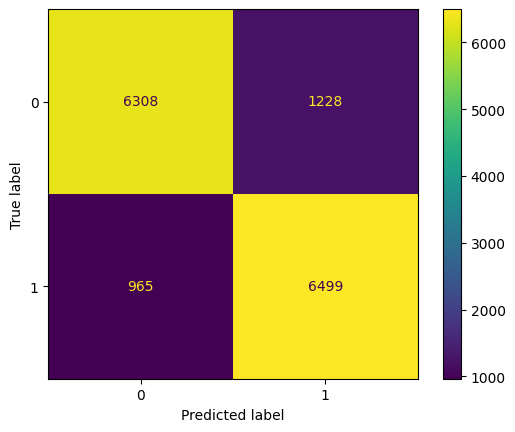

In [53]:
imprimir_resultados(y_test_, y_pred)

In [54]:
y_pred_ = best_nb.predict(vectorizer.transform(x_test))

In [55]:
guardar_resultado_en_csv(y_pred_)

In [56]:
## Testeo

In [57]:
pd.DataFrame(y_pred, columns=['Etiqueta_Predicha'])
pd.DataFrame({'review_es': x_test})
pd.DataFrame({'review_es': y_test_})


,review_es
31809,negativo
34702,negativo
14222,negativo
26294,negativo
9876,negativo
...,...
17070,negativo
2268,negativo
12053,positivo
28604,negativo


In [58]:
a = pd.DataFrame({'review_es': x_test_})
a.reset_index(drop=True, inplace=True)

In [59]:
b = pd.DataFrame({'sentimiento': y_test_})
b.reset_index(drop=True, inplace=True)

In [60]:
c = pd.DataFrame(y_pred, columns=['Prediccion'])
c.reset_index(drop=True, inplace=True)

In [61]:
df_resultado = pd.concat([a, b, c], axis=1)

In [62]:
df_resultado_filtro = df_resultado[df_resultado['sentimiento'] != df_resultado['Prediccion']]

In [63]:
df_resultado_filtro

,review_es,sentimiento,Prediccion
3,estatiene todas las asignaciones de demasiados...,negativo,positivo
6,"por todas las apariencias, esta serie podría h...",negativo,positivo
7,"escogí esto por un capricho de la biblioteca, ...",positivo,negativo
12,"esta es una grande tiburones italianos, probab...",positivo,negativo
22,es este tipo deque intentas e imitar.al intent...,positivo,negativo
...,...,...,...
14961,"para empezar, me encantó göta kanal 1, tenía m...",positivo,negativo
14963,recuerdo haber visto a esta mini-series la pri...,negativo,positivo
14981,"bueno, supongo que tendré que ser quien decir ...",negativo,positivo
14982,algunas de mis películas favoritas de laurel y...,positivo,negativo
